---
# Practical 7: Discordance, gene flow and ABBA BABA
---

At the end of this practical you should

* Understand how and why the shape (topology) of genealogies changes along the genome
    * The concept of incomplete lineage sorting
    * The effect of population size and split time on discordance
    * The effect of gene flow on discordance


* Know how to perform and analyse multiple-population simulations
    * Defining simulation models
    * Analysing tree sequences and genealogy shapes


* Understand how mutation patterns ("ABBA" and "BABA") provide evidence for gene flow
    * Write python functions to compute these summaries
    * Understand the difference between the *D* statistic and the proportion of introgression *f*
    * Understand how to use parametric bootstrapping to evaluate evidence for introgression



### Preparation

Download the folder containing data files necessary for this project and unzip. Note these commands start with the `!` symbol because they are bash commands.

In [ ]:
#download
!wget -O Prac7_data.tar.gz https://www.dropbox.com/s/u9jz9nrs617w4b3/Prac7_data.tar.gz?dl=0

#unzip
!tar -xzf Prac7_data.tar.gz

Import the necessary python packages.

In [1]:
import msprime
import tskit
import demes
import demesdraw
import numpy as np
import allel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import SVG, set_matplotlib_formats

---
# 1. Genealogical discordance

## 1.1 Tree topologies

To start thinking about the shape (topology) of genealogies, we will start with the simplest possible case, where we have just three leaves.

### 1.1.1 All possible topologies for a tree with trhee leaves

For a given set of tip labels, there is a limited number of tree topologies. We will use the [`rank()`](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Tree.rank) function of `tskit`, which gives a unique code to each tree topology.

`tskit` also provides the [`all_trees()`](https://tskit.dev/tskit/docs/stable/python-api.html?highlight=all_trees#tskit.all_trees) function to generates all possible tree topologies for a given number of leaves.



This tree has topology rank (0, 0).
Newick format: (0,1,2);


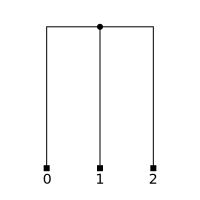



This tree has topology rank (1, 0).
Newick format: (0,(1,2));


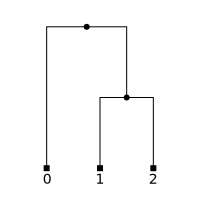



This tree has topology rank (1, 1).
Newick format: (1,(0,2));


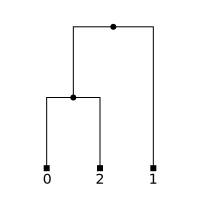



This tree has topology rank (1, 2).
Newick format: (2,(0,1));


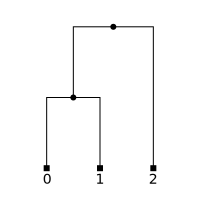

In [2]:
#generate all possible topologies and store as tskit tree objects
topos = tskit.all_trees(3)

#visualise and report the rank of each tree topology
for t in topos:
    print("\n\nThis tree has topology rank {}.".format(t.rank()))
    print("Newick format:", t.newick(node_labels={0: 0, 1: 1, 2: 2}, include_branch_lengths=False))
    display(SVG(t.draw(node_labels={0: 0, 1: 1, 2: 2})))

So there are **four** possible topologies for a tree with three leaves, with ranks `(0,0)`, `(1,0)`, `(1,1)` and `(1,2)`. The latter **three** of these are *bifurcating*.

A topology ranks is a tuples of two integers. The first value corresponds to the shape of the tree and the second to the order of the labels.

**We will be using these ranks below to identify the shape of each genealogy along the genome in simulated treesequences**, and thereby compare the abundance of different topologies.

Because the ranks are not very informative, we will create a dictionary that allows us to convert the rank to a [newick format](https://en.wikipedia.org/wiki/Newick_format) tree.


In [3]:
rank_to_nwk = {}

for t in tskit.all_trees(3):
    rank = t.rank()
    nwk_string = t.newick(node_labels={0: 0, 1: 1, 2: 2}, include_branch_lengths=False)
    rank_to_nwk[rank]=nwk_string

rank_to_nwk

{(0, 0): '(0,1,2);',
 (1, 0): '(0,(1,2));',
 (1, 1): '(1,(0,2));',
 (1, 2): '(2,(0,1));'}

Under coalescent theory, the probability of a polytomy (more than two lineages coalesce in a single generation) is negligable. Standard coalescent simulations only produce bifurcating trees. We will therefore not encounter the first topology with rank `(0,0`) in this practical.

### 1.1.2 The probability of each topology in a bifurcating species tree

<div class="alert alert-block alert-info">
    <b>Popgen: Topology likelihoods</b> 
    
In Lecture 7 we saw that, under a species tree with topology `((0,1),2)`, the likelihood of the three topologies are: 

$$Pr[((0,1),2)] = \frac{1}{3} e^{-t/2N} + (1-e^{-t/2N}) $$

$$Pr[((0,2),1)] = \frac{1}{3} e^{-t/2N} $$

$$Pr[((1,2),0)] = \frac{1}{3} e^{-t/2N} $$


Where $t$ refers to the length of the branch ancestral to poulations 0 and 1, and $N$ the effective population size of this population.

Thus, we always expect the species topology `((0,1),2)` to be as common or more common that the two discordant topologies <b>in the absence of gene flow </b>.
    </div>

## 1.2 Simulations

Now we will test our understanding of discordant genealogies using simulations.

### 1.2.1 Setting up the demographic model

Our underlying model has three populations (or species) with the relationship ((X, Y), Z).

The **species tree** has:
- 3 'tip' branches, leading to X, Y and Z
- 1 'internal' branch, ancestral to X and Y
- 1 'ancestral' branch ancestral to X, Y and Z
- 2 split times:
    - The time at which X diverges from Y
    - The time at which Z diverges for the XY ancestor

We will run coalescent simulations in `msprime`. This allows any number of samples and complex demographic histories. To simplify setting up the demographic model, we will use the package [`demes`](https://popsim-consortium.github.io/demes-docs/latest/introduction.html).

Our model is generated ***inside*** **a python function**, which returns a [`demes.Graph`](https://popsim-consortium.github.io/demes-docs/latest/api.html#working-with-demes-graphs) object. This is a useful way to set up a simulation model if you intend to run it multiple times and modify parameters. Our function will allow us to set the sizes of each of the populations, and the split times.


In [9]:
#demographic model. Tree has shape ((X,Y),Z))
def three_pop_model(t_XY=2e4, t_XYZ=4e4,                                 #split times
                    N_X=1e4, N_Y=1e4, N_Z = 1e4, N_XY=1e4, N_XYZ=1e4):   #population sizes
    
    #use the deme builder to set up the demographic history
    b = demes.Builder(time_units="generations")
    b.add_deme("XYZanc",                      epochs=[{"start_size":N_XYZ, "end_time":t_XYZ}])
    b.add_deme("XYanc", ancestors=["XYZanc"], epochs=[{"start_size":N_XY,  "end_time":t_XY}])
    b.add_deme("X",     ancestors=["XYanc"],  epochs=[{"start_size":N_X}])
    b.add_deme("Y",     ancestors=["XYanc"],  epochs=[{"start_size":N_Y}])
    b.add_deme("Z",     ancestors=["XYZanc"], epochs=[{"start_size":N_Z}])
    
    graph = b.resolve()
    
    return(graph)

Note that running the code in the above cell does not produce an output. It just saves the fucntion ready for use.

We can call our function to generate a model graph object, and we can make a pretty visualisation of this using the [`tubes()`](https://grahamgower.github.io/demesdraw/latest/quickstart.html#demes-as-tubes) function of `demesdraw`.

<AxesSubplot:title={'center':'Three population model'}, ylabel='time ago (generations)'>

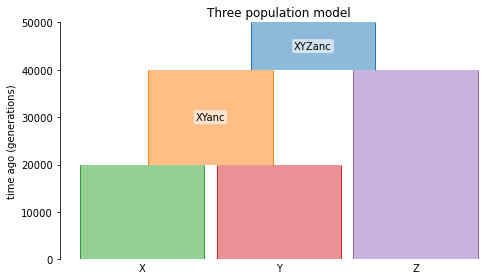

In [10]:
#make demographic model and plot it to check that it looks right
model_graph = three_pop_model()

#cute visualisation with demesdraw
demesdraw.tubes(model_graph, title = "Three population model")

### 1.2.2 Simulating a treesequence

Now we simulate our first treesequence. We first convert the demographic model from `demes` into a `msprime.Demography` object, and then generate our treesequence, which will be 5 Million bp, with a recombination rate of 5e-8.

In [11]:
# Convert the demographic model into msprime format
demography = msprime.Demography.from_demes(model_graph)

#simulate a treesequence
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},
                          demography=demography, sequence_length = 5e6,
                          recombination_rate = 5e-8, ploidy=1)

print("This treesequence has", ts.num_trees, "trees.")

This treesequence has 11991 trees.


We can take a look at the first tree to confirm we have just three leaves

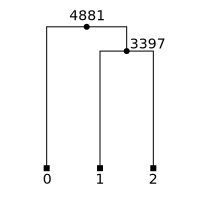

In [12]:
SVG(ts.first().draw_svg())

A treesequence simulated in msprime carries information about which population each individual was sampled from. We can therefore check to confirm that `0` comes from population `X`, `1` from population `Y` and `2` from `Z`.

<div class="alert alert-block alert-warning">
    <b>Python recipe: string format() method</b> 
    
You can insert variables into a string by adding `{}` into the string, and then adding `.format()` after the string. This can make the code easier to read than long print statements separated by commas.
    </div>

In [13]:
for s in ts.samples():
    pop_number = ts.get_population(s)
    pop_name = ts.populations()[pop_number].metadata["name"]
    print("Sample {} is from population {}, which is named {}".format(s, pop_number, pop_name))

Sample 0 is from population 2, which is named X
Sample 1 is from population 3, which is named Y
Sample 2 is from population 4, which is named Z


Note that each population has a number as well as a 'name', which we gave it in the simulation. The population *number* depends on the *order* in which they appear in the demographic model, whereas the *name* is *defined by us* in the demographic model.

## 1.3 The abundance of different topologies in a treesequence

Now we would like to know how many of the genealogies along our treesequence represent each of the three possible topologies:

`(2,(0,1))` = `((X,Y),Z)` is the species tree topology.

`(1,(0,2))` = `((X,Z),Y)` **is discordant** with the species tree topology.

`(0,(1,2))` = `((Y,Z),X)` **is discordant** with the species tree topology.

We don't have to worry about the fourth topology `(0,1,2)` because it is not bifurcating, and therefore will not be generated using the standard coalescence algorithm implemented by `msprime`.


### 1.3.1 Counting topologies in the treesequence

We will iterate over the treesequence and for each topology, we gt its rank (which we convert to newick format for convenience) and then add it to the appropriate list.


In [14]:
#a dictionary to record which trees correspond to each topology
topo_matches = {'(2,(0,1));':[],
                '(1,(0,2));':[],
                '(0,(1,2));':[]}

# for each tree, we add its index to the appropriate list based on its rank
for i,tree in enumerate(ts.trees()):
    rank = tree.rank()
    nwk_string = rank_to_nwk[rank]
    topo_matches[nwk_string].append(i)

We can now see home many trees matched each topology by looking at the length of each list in the dictionary we have just made.

In [15]:
#Count and print the number of each topology type
for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    n = len(topo_matches[nwk_string]) #number of trees with this topology
    print("\nThere are {} trees with topology {}\n".format(n, nwk_string))


There are 10689 trees with topology (2,(0,1));


There are 656 trees with topology (1,(0,2));


There are 646 trees with topology (0,(1,2));



So even though we simulated under a defined speacies tree, we see all three possible bifurcating topologies occuring within our treesequence.

<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b>  
Compute the proportion of genealogies that are discordant with the species tree.
    

**Hint:** Remember the two discordant topologies are `(1,(0,2));` and `(0,(1,2));`. As above, use the `len()` function to extract the number of topologies from the `topo_matches` dictionary, then sum the numbers for the two discordant topologies and divide by the total number of trees in the treesequence (`ts.num_trees`).
    </div>

In [16]:
#SOLUTION:
discordant = len(topo_matches['(1,(0,2));']) + len(topo_matches['(0,(1,2));'])
                                          
print("\nThe proportion of discordant genealogies is", discordant/ts.num_trees)


The proportion of discordant genealogies is 0.1085814360770578


### 1.3.2 The proportion of the genome that is discordant

It is important to note that the proportion of discordant genealogies is **not** the same as the **proportion of the genome that is discordant with the species tree.**

You will recall from Practical 3 that the lengths (or spans) of tracts with different genealogies are not all equal, so to calculate the total length of genome with a given topology, we need to sum the spans of all the corresponding trees.

We use a similar approach to above, using a python dictionary to store the **span** of each tree with each rank.

In [17]:
#a dictionary to record the tree spans each topology
tree_spans = {'(2,(0,1));':[],
              '(1,(0,2));':[],
              '(0,(1,2));':[]}

# for each tree, we add its span to the appropriate list based on its rank
for i,tree in enumerate(ts.trees()):
    rank = tree.rank()
    nwk_string = rank_to_nwk[rank]
    tree_spans[nwk_string].append(tree.span)

for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    total_span = sum(tree_spans[nwk_string])
    print("\nTrees with topology {} total {} bp\n".format(nwk_string, total_span))


Trees with topology (2,(0,1)); total 4548980.0 bp


Trees with topology (1,(0,2)); total 223530.0 bp


Trees with topology (0,(1,2)); total 227490.0 bp



<div class="alert alert-block alert-success">    
    <b>Exercise 2:</b>  
Compute the proportion of the genome made up of discordant genealogies.
    </div>

In [18]:
#propotion of the genome that is dicordant
discordant_span = sum(tree_spans['(1,(0,2));']) + sum(tree_spans['(0,(1,2));'])
print("The proportion of the genome that is discordant is", discordant_span/ts.sequence_length)

The proportion of the genome that is discordant is 0.090204


<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>
    
Why do we see genealogies that are discordant with the species tree under which we ran our simulations?

Why is the proportion of the genome that is discordant lower than the proportion of *genealogies* that are discordant?
    </div>

<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b>  
Test the logic we have just discussed by calculating the average span of each tree topology.

**Hint:** We have already stored the spans in the `tree_spans` dictionary. You can use the `np.mean()` function to get the mean of each.
    </div>

In [19]:
#SOLUTION:
print("Mean span of species tree topology (2,(0,1)):", np.mean(tree_spans['(2,(0,1));']))
print("Mean span of discordant topology (1,(0,2)):", np.mean(tree_spans['(1,(0,2));']))
print("Mean span of discordant topology: (0,(1,2)):", np.mean(tree_spans['(0,(1,2));']))

Mean span of species tree topology (2,(0,1)): 425.57582561511833
Mean span of discordant topology (1,(0,2)): 340.7469512195122
Mean span of discordant topology: (0,(1,2)): 352.1517027863777


---
# 2. Exploring factors that affect the extent of discordance

We have generated a pipeline to determine the proportion of the genome that is discordant under a given simulation model. We will now explore the effects of various modifications to the model to test theoreticl predictions.

## 2.1 Factors that alter the extent of incomplete lineage sorting

### 2.1.1 Effect of population size


<div class="alert alert-block alert-success">    
    <b>Exercise 4:</b>
What effect does decreasing or increasing the size of each population have on the proportion of discordant trees?

**Hint:** We can generate a new demographic model with a modified population size using a command like `three_pop_model(N_X=2e4)`. Then use the necessary code snipets from above to **simulate a new tree sequence**, calculate the **proportion** of the genome that is discordant.
    </div>


Trees with topology (2,(0,1)); total 3777699.0 bp


Trees with topology (1,(0,2)); total 618670.0 bp


Trees with topology (0,(1,2)); total 603631.0 bp

The proportion of the genome that is discordant is 0.2444602


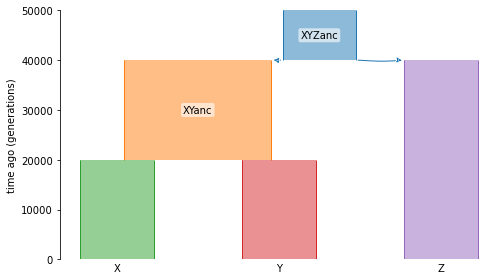

In [20]:
#SOLUTION:
# simulate treesequence with one population size modified
#make demographic model and plot it to check that it looks right
model_graph = three_pop_model(N_XY=2e4) #re-run this code but altering different populations and making them smaller or larger

demesdraw.tubes(model_graph) 

# Convert the demographic model into msprime format
demography = msprime.Demography.from_demes(model_graph)

#simulate a treesequence
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},
                          demography=demography, sequence_length = 5e6,
                          recombination_rate = 5e-8, ploidy=1)

#a dictionary to record the tree spans each topology
tree_spans = {'(2,(0,1));':[],
              '(1,(0,2));':[],
              '(0,(1,2));':[]}

# for each tree, we add its span to the appropriate list based on its rank
for i,tree in enumerate(ts.trees()):
    rank = tree.rank()
    nwk_string = rank_to_nwk[rank]
    tree_spans[nwk_string].append(tree.span)

for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    total_span = sum(tree_spans[nwk_string])
    print("\nTrees with topology {} total {} bp\n".format(nwk_string, total_span))

#propotion of the genome that is discordant
discordant_span = sum(tree_spans['(1,(0,2));']) + sum(tree_spans['(0,(1,2));'])
print("The proportion of the genome that is discordant is", discordant_span/ts.sequence_length)

### 2.1.2 Effect of split times


<div class="alert alert-block alert-success">    
    <b>Exercise 5:</b>
What effect does altering the split times have on the proportion of discordant trees, and why?

**Hint:** Split times in the simulation model can be specified with commands like `three_pop_model(t_XY=5e3)`.
    </div>


Trees with topology (2,(0,1)); total 4893209.0 bp


Trees with topology (1,(0,2)); total 51517.0 bp


Trees with topology (0,(1,2)); total 55274.0 bp

The proportion of the genome that is discordant is 0.0213582


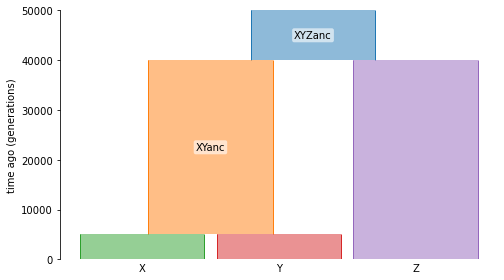

In [21]:
## SOLUTION:
# simulate treesequence with one population smaller than the others
model_graph = three_pop_model(t_XY=5e3) #re-run this code but altering the split times

demesdraw.tubes(model_graph) 

# Convert the demographic model into msprime format
demography = msprime.Demography.from_demes(model_graph)

#simulate a treesequence
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},
                          demography=demography, sequence_length = 5e6,
                          recombination_rate = 5e-8, ploidy=1)

#a dictionary to record the tree spans each topology
tree_spans = {'(2,(0,1));':[],
              '(1,(0,2));':[],
              '(0,(1,2));':[]}

# for each tree, we add its span to the appropriate list based on its rank
for i,tree in enumerate(ts.trees()):
    rank = tree.rank()
    nwk_string = rank_to_nwk[rank]
    tree_spans[nwk_string].append(tree.span)

for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    total_span = sum(tree_spans[nwk_string])
    print("\nTrees with topology {} total {} bp\n".format(nwk_string, total_span))

#propotion of the genome that is discordant
discordant_span = sum(tree_spans['(1,(0,2));']) + sum(tree_spans['(0,(1,2));'])
print("The proportion of the genome that is discordant is", discordant_span/ts.sequence_length)

<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>

Which population size and which split times affected the level of discordance? Why?
    </div>

## 2.2 Effect of gene flow

Now we are going to introduce gene flow as an additional process in our model to see how it alters the proportions of discordant tree topologies.

### 2.2.1 Adding gene flow into the demographic model

For this we need to modify our demgraphic model to include migration rates between pairs of populations. We will consider all possible migrations:

X <- Y and X -> Y

X <- Z and X -> Z

Y <- Z and Y -> Z

XY_anc <- Z and XY_anc -> Z


<div class="alert alert-block alert-info">
    <b>Popgen: Gene flow and topology likelihoods</b> 
    
Gene flow will change topology likelihoods if it changes the rate of coalescence between two lineages. For example, gene flow between populations X and Y increases their rate of coalesence, thereby increasing the likelihood of the species topology and decreasing the likelihood of discordance.
    </div>

In [22]:
#demographic model including gene flow (called migration in these models)
def three_pop_model(t_XY=2e4, t_XYZ=4e4,
                    N_X=1e4, N_Y=1e4, N_Z = 1e4, N_XY=1e4, N_XYZ=1e4,
                    m_X_to_Y=0, m_Y_to_X=0,
                    m_X_to_Z=0, m_Z_to_X=0,
                    m_Y_to_Z=0, m_Z_to_Y=0,
                    m_XYanc_to_Z=0, m_Z_to_XYanc=0):
    
    #use the deme builder to set up the demographic history
    b = demes.Builder(time_units="generations")
    b.add_deme("XYZanc",                      epochs=[{"start_size":N_XYZ, "end_time":t_XYZ}])
    b.add_deme("XYanc", ancestors=["XYZanc"], epochs=[{"start_size":N_XY,  "end_time":t_XY}])
    b.add_deme("X",     ancestors=["XYanc"],  epochs=[{"start_size":N_X}])
    b.add_deme("Y",     ancestors=["XYanc"],  epochs=[{"start_size":N_Y}])
    b.add_deme("Z",     ancestors=["XYZanc"], epochs=[{"start_size":N_Z}])
    
    #add migration to the model, but only if the rate specified is > 0
    if m_X_to_Y > 0: b.add_migration(source="X", dest="Y", rate=m_X_to_Y)
    if m_Y_to_X > 0: b.add_migration(source="Y", dest="X", rate=m_Y_to_X)
    if m_X_to_Z > 0: b.add_migration(source="X", dest="Z", rate=m_X_to_Z)
    if m_Z_to_X > 0: b.add_migration(source="Z", dest="X", rate=m_Z_to_X)
    if m_Y_to_Z > 0: b.add_migration(source="Y", dest="Z", rate=m_Y_to_Z)
    if m_Z_to_Y > 0: b.add_migration(source="Z", dest="Y", rate=m_Z_to_Y)
    if m_XYanc_to_Z > 0: b.add_migration(source="XYanc", dest="Z", rate=m_XYanc_to_Z)
    if m_Z_to_XYanc > 0: b.add_migration(source="Z", dest="XYanc", rate=m_Z_to_XYanc)
    
    graph = b.resolve()
    
    return(graph)

### 2.2.2 Simulations with gene flow

We will start by adding migration between X and Y and then examining its effect on the proportion of discordance.

First we will build our new demographic model including migration and have a look at the graph. Migration rates are specified as a proportion of the population made up of immigrants each generation. So we use a **small number**.

<AxesSubplot:ylabel='time ago (generations)'>

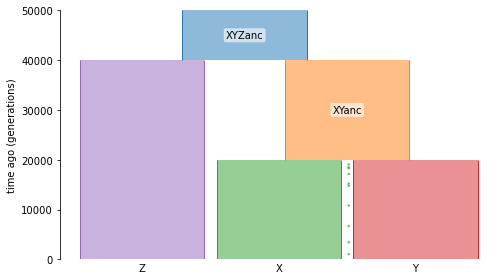

In [23]:
# Model with migration for X to Y
model_graph = three_pop_model(m_X_to_Y=1e-5)

demesdraw.tubes(model_graph)

Note the arrows added betwen X and Y showing unidirectional gene flow from X into Y.

We can now simulate using this new model to see what this does to the level of discordance.

In [24]:

# Convert the demographic model into msprime format
demography = msprime.Demography.from_demes(model_graph)

#simulate a treesequence
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},
                          demography=demography, sequence_length = 5e6,
                          recombination_rate = 5e-8, ploidy=1)

#a dictionary to record the tree spans each topology
tree_spans = {'(2,(0,1));':[],
              '(1,(0,2));':[],
              '(0,(1,2));':[]}

# for each tree, we add its span to the appropriate list based on its rank
for i,tree in enumerate(ts.trees()):
    rank = tree.rank()
    nwk_string = rank_to_nwk[rank]
    tree_spans[nwk_string].append(tree.span)

for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    total_span = sum(tree_spans[nwk_string])
    print("\nTrees with topology {} total {} bp\n".format(nwk_string, total_span))

#propotion of the genome that is discordant
discordant_span = sum(tree_spans['(1,(0,2));']) + sum(tree_spans['(0,(1,2));'])
print("The proportion of the genome that is discordant is", discordant_span/ts.sequence_length)


Trees with topology (2,(0,1)); total 4663371.0 bp


Trees with topology (1,(0,2)); total 167645.0 bp


Trees with topology (0,(1,2)); total 168984.0 bp

The proportion of the genome that is discordant is 0.0673258


We see that migration between X and Y **decreases** discordance. This is because it *increases* opportunities for coalescence between lineages from X and Y.

<div class="alert alert-block alert-success">    
    <b>Exercise 6:</b>
What is the effect of migration between other populations on the level of discordance?

**Hints:**
    <li>Pay attention to the **relative proportion the two discordant topologies**. Can you explain why some types of gene flow affect these relative proportions?</li>
    <li>`demesdraw` sometimes displays the model in strange ways to fit the migration arrows in, so don't be alarmed.</li>
    </div>


Trees with topology (2,(0,1)); total 3675623.0 bp


Trees with topology (1,(0,2)); total 1116038.0 bp


Trees with topology (0,(1,2)); total 208339.0 bp

The proportion of the genome that is discordant is 0.2648754


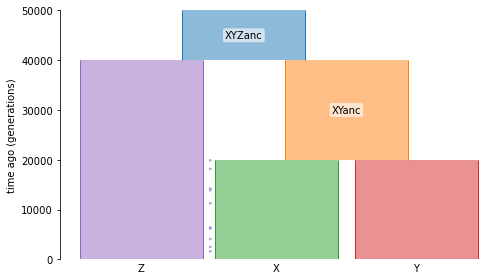

In [25]:
## SOLUTION:
# simulate treesequence with one population smaller than the others
model_graph = three_pop_model(m_Z_to_X=1e-5)

demesdraw.tubes(model_graph)

# Convert the demographic model into msprime format
demography = msprime.Demography.from_demes(model_graph)

#simulate a treesequence
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},
                          demography=demography, sequence_length = 5e6,
                          recombination_rate = 5e-8, ploidy=1)

#a dictionary to record the tree spans each topology
tree_spans = {'(2,(0,1));':[],
              '(1,(0,2));':[],
              '(0,(1,2));':[]}

# for each tree, we add its span to the appropriate list based on its rank
for i,tree in enumerate(ts.trees()):
    rank = tree.rank()
    nwk_string = rank_to_nwk[rank]
    tree_spans[nwk_string].append(tree.span)

for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    total_span = sum(tree_spans[nwk_string])
    print("\nTrees with topology {} total {} bp\n".format(nwk_string, total_span))

#propotion of the genome that is discordant
discordant_span = sum(tree_spans['(1,(0,2));']) + sum(tree_spans['(0,(1,2));'])
print("The proportion of the genome that is discordant is", discordant_span/ts.sequence_length)

<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>

Which migrations affected the level of discordance? Why?

Which migrations caused assymetry in the number of discordant topologies?

What would happen to the proportion of species topologies if migration between populations Z and X is extremely high?
    </div>

---
# 3. Investigating gene flow between Neanderthals and modern humans with real data

We will now turn to some real data from hominids and ask whether there is evidence of historical gene flow between Neanderthals and modern humans. We will be using the *D* statistic described in detail by [Durand et al. 2011](https://doi.org/10.1093/molbev/msr048).

Our data from **modern humans** comes from the 1000 Genomes Project, now hosted by the [IGSR: The International Genome Sample Resource](https://www.internationalgenome.org/).

Our data from **Neanderthals** comes from the [Altai Neanderthal Genome](https://www.eva.mpg.de/genetics/genome-projects/neandertal/) [[original publication](https://doi.org/10.1038/nature12886)].

Finally, in order to compute the *D* statistic, we need an outgroup to polarise our data.

We will use chimpanzee data from [the genome of a chimp called Clint](https://www.ncbi.nlm.nih.gov/assembly/GCF_002880755.1/).

All of this data has been aligned to the [human reference genome build 37](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.13/).

The archaic genomes were generated from ancient DNA, and therefore many CpG sites will have undergone post-mortem deamination to TpG. Therefore, all observed and potential CpG sites have been removed.

Finally, we are only analysing chromosome 1, for efficiency.


## 3.1 Introgression analysis using single haploid genomes ###

The simplest form of introgression analysis we can do uses just a single haploid genome from each of four populations.

* An outgroup (in this case, chimp assembly `panTro6`)
* A putative donor (P3) (in this case, Altai Neanderthal `AltaiNea`)
* A putative recipient (P2) (in this case a randomly chosen British individual `HG00096`)
* A control population (P1) (in this case a randomly chosen Nigerian of Yaruban ancestry `NA18488`)

We have downsampled the genomes to a single haploid base to simplify this analysis.

### 3.1.1 Loading the data from a VCF file

We start be defining the fields we are interested in in the VCF. In this case, just the sample names and genotypes. Then load the VCF using `allel`.

In [26]:
query_fields = ['samples', 'calldata/GT']

vcf_dict = allel.read_vcf('Prac7_data/YRI1rndm_GBR1rndm_ALTrndm_chimp.chr1.SNP.vcf.gz', fields=query_fields)

Check the sample names.

In [27]:
print("Samples: ", vcf_dict['samples'])

Samples:  ['NA18488' 'HG00096' 'AltaiNea' 'panTro6']


We can look at the variants array to ensure it has been loaded correctly

In [28]:
print(vcf_dict['calldata/GT'])
vcf_dict['calldata/GT'].shape

[[[ 0 -1]
  [ 1 -1]
  [ 0 -1]
  [-1 -1]]

 [[ 0 -1]
  [ 0 -1]
  [ 0 -1]
  [ 1 -1]]

 [[ 1 -1]
  [ 0 -1]
  [ 1 -1]
  [-1 -1]]

 ...

 [[ 0 -1]
  [ 0 -1]
  [ 0 -1]
  [ 1 -1]]

 [[ 0 -1]
  [ 0 -1]
  [ 0 -1]
  [ 1 -1]]

 [[ 0 -1]
  [ 0 -1]
  [ 0 -1]
  [ 1 -1]]]


(393776, 4, 2)

`0` indicates the reference base and `1` indicates the alternate base. `-1` indicates missing data.

Note that the array has three dimensions:
1. Variants (393776)
2. Samples (4)
3. Alleles within each sample (2)

So there are two genotypes recorded at each site for each sample, but the second one is always 'missing' (`-1`). This is because the `read_vcf()` function of `allel` assumes diploid data, so reading a haploid file always results in one missing genotype.

To get around this we can simply ignore the second entry in the third dimension, thereby creating a 2-dimensional haplotype array.

In [29]:
#extract only first allele and convert to pandas dataframe
haplotypes = pd.DataFrame(vcf_dict['calldata/GT'][:,:,0])

#add labels
haplotypes.columns = ["Afr", "Eur", "Nea", "Chimp"]

haplotypes

,Afr,Eur,Nea,Chimp
0,0,1,0,-1
1,0,0,0,1
2,1,0,1,-1
3,0,0,-1,1
4,1,0,-1,0
...,...,...,...,...
393771,0,0,0,1
393772,0,0,0,1
393773,0,0,0,1
393774,0,0,0,1


### 3.1.2 Filtering to retain only useful sites

Note that there is still some missing data in the haplotype array. Both the chimp and neanderthal were aligned to the human reference genome, and sites at whcih alignment was unreliable are defined as missing (`-1`). This also happens when aligning genomes from the same species, but all missing data in the 1000 genomes data set has been "imputed".

The sites with missing data are not useful for our analysis, so we flag and remove these sites.

We also want to retain only biallelic sites. We will define these as sites at which only the human reference allele `0` and one alternate allele `1` is present. All sites with more than one alternate allele is present (alleles numbered `2` or more), will be excluded.

In [30]:
#identify biallelic sites and those without missing data
biallelic = haplotypes.max(axis=1) == 1
nomissing = haplotypes.min(axis=1) == 0

#subset the haplotypes using the np.where() function
haplotypes = haplotypes[biallelic & nomissing]

haplotypes

,Afr,Eur,Nea,Chimp
1,0,0,0,1
5,0,0,1,0
6,0,0,0,1
7,0,0,0,1
8,0,0,0,1
...,...,...,...,...
393771,0,0,0,1
393772,0,0,0,1
393773,0,0,0,1
393774,0,0,0,1


<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>
    
Our dataset was downsampled from the 1000 Genomes data. Why might wasteful to only use biallelic sites that have alleles `0` and `1` in our dataset?
    </div>

### 3.1.3 Polarising the data

<div class="alert alert-block alert-info">
    <b>Popgen: Ancestral and Derived alleles</b>

For many applications it is useful to know which allele is <b>ancestral</b>, and which is <b>derived</b> (i.e. to "polarise" the mutations). For simulated data, this is known, but in real data we have to infer the ancestral state by examination of related taxa. For example, if there are two alleles segregating within humans and only one of these is observed in the champanzee, we can infer that the allele shared by the chimpanzee is ancestral. This implies that the derived allele arose within the human lineage after the divergence between human and chimp (~6 MYA). This inference is fairly safe because it is unlikely that there is much incomplete lineage sorting in the long branch ancestral to all humans over this timeframe.
    </div>

Currently, alleles are numbered according to whether they match the human **reference** genome (`0`) or **alternate** allele (`1`). This is ***not*** the same as **ancestral** and **derived** alleles.

To polarise our data, we will assume that the chimp always carries the ancestral allele, which we want to be represented by `0`. We therefore need to identify all sites at which the chimp allele is currently `1`, and 'flip' these, by converting `1` to `0` and `0` to `1` **in all individuals**.

In [31]:
sites_to_flip = haplotypes.Chimp == 1

#a new object to contain the polarised haplotypes
haplotypes_pol = haplotypes.copy()

#subtracting from 1 will convert 1s to 0s and 0s to 1s
haplotypes_pol[sites_to_flip] = 1 - haplotypes[sites_to_flip]

print(haplotypes_pol)

        Afr  Eur  Nea  Chimp
1         1    1    1      0
5         0    0    1      0
6         1    1    1      0
7         1    1    1      0
8         1    1    1      0
...     ...  ...  ...    ...
393771    1    1    1      0
393772    1    1    1      0
393773    1    1    1      0
393774    1    1    1      0
393775    1    1    1      0

[384107 rows x 4 columns]


### 3.1.3 ABBA BABA and D statistic

<div class="alert alert-block alert-info">
    <b>Popgen: ABBA BABA statistics</b>

Although we cannot observed genealogies directly from SNP data, we can use the "ABBA" and "BABA" site patterns as proxies for genealogical discordance. These are sites at which the Neanderthal shares a derived allele with either the European (ABBA) or African (BABA).

Under a simple bifurcating model without gene flow, the **relative** proportion of the two types of discordant topologies is **equal**, **regardless of population sizes and split times**. Therefore, the expected frequencies of ABBA and BABA mutation patterns is also equal under this null model.

In reality, recurrent mutation at the same site in different lineages can also give rise to ABBA and BABA patterns, but this should also lead to equivalent numbers of both, unless mutation rates are unequal between populations, which is [currently a controversial idea](https://doi.org/10.1098/rsos.191900). We will therefore assume that a deviation from equality in the number of ABBA and BABA sites is indicative of gene flow between Neanderthals and one of the modern human populations. The $D$ statistic provides a test for a deviation from this expected equilibrium.
    
$$ D = \frac{\sum{ABBA} - \sum{BABA}}{\sum{ABBA} + \sum{BABA}} $$
    
</div>

Given that the samples are already ordered \[African, European, Neanderthal, Chimp\], we can easliy identify ABBA sites as those at which the genotypes are `[0,1,1,0]` and BABA sites where the genotypes are `[1,0,1,0]`. The `numpy.all()` function ensures that all of genotypes match the pattern defined.

In [32]:
#creat a logical array indicating whether each site matches the ABBA or BABA pattern
ABBA = np.all(haplotypes_pol == [0,1,1,0], axis=1)
BABA = np.all(haplotypes_pol == [1,0,1,0], axis=1)

#Sum the logical array to get the total count
print("ABBA sites:", ABBA.sum())
print("BABA sites:", BABA.sum())

ABBA sites: 16479
BABA sites: 14873


<div class="alert alert-block alert-success">    
    <b>Exercise 7:</b>
Compute and print the D statistic, which is the normalised difference between the total number of ABBA and BABA sites
    </div>

In [33]:
#SOLUTION:
D = (ABBA.sum() - BABA.sum()) / (ABBA.sum() + BABA.sum())

print("D:", D)

D: 0.05122480224547078


A positive *D* indicates excess of ABBA sites, consitent with **introgression between the Neanderthal and the European**. Below we will investigate the statistical significance of this D value, but first we will consider the proportion of introgression.

Note that *D* is not the same as the proportion of this individual's genome that is of Neanderthal origin. To estimate that parameter we need to take a slightly different approach.

### 3.1.4 Estimating *f*: the proportion of introgression


<div class="alert alert-block alert-info">
    <b>Popgen: Proportion of introgression</b>

To estimatate <i>f</i>, the proportion of this individual's genome that is of Neanderthal origin, we will use a common approach that compares the observed and expected excess of ABBA and BABA sites.

We will estimate the expected number of ABBA and BABA sites under the scenario that gene flow is complete, such that the <i>European is 100% Neanderthal</i>. A crude way to do this is to substitute the Neanderthal in for the European. In other words, we are calculating ABBA and BABA sites but with the Neanderthal genome used to represent *both* the Neanderthal and the European. If we had two Neanderthal genomes, we could have used one for each, but since we only have one, we will use it in both positions.

We compare this hypothetical excess of ABBA over BABA to our observed excess to estimate *f*.
    
$$ f = \frac{\sum{ABBA}[Afr, Eur, Nea, Chimp] - \sum{BABA}[Afr, Eur, Nea, Chimp] } {\sum{ABBA}[Afr, Nea, Nea, Chimp] - \sum{BABA}[Afr, Nea, Nea, Chimp]} $$

You might notice that, under this strict substitution scenario, BABA sites are all impossible because the Neanderthal and "European" (which is also represented by the same Neanderthal haplotype) cannot differ. Had we used two separate neanderthals, there would have been some BABA sites in the denominator.
</div>

The denominator for f estimation requires that we re-count ABBA and BABA sites but with the neanderthal substituted in place of the European.

In [34]:
#possible ABBAs are sites at which the African is 0, the Neanderthal is 1 and the chimp is 0
ABBA_possible = np.all(haplotypes_pol[["Afr","Nea","Nea","Chimp"]] == [0,1,1,0], axis=1)
BABA_possible = np.all(haplotypes_pol[["Afr","Nea","Nea","Chimp"]] == [1,0,1,0], axis=1)

f = (ABBA.sum() - BABA.sum()) / (ABBA_possible.sum() + BABA_possible.sum())

print("f:", f)

f: 0.018994677705499705


So our randomly chosen British individual has an estimated ~2% of neanderthal ancestry on chromosome 1.

<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>

Because we had only one Neanderthal genome, we have made the assumption that under complete introgression, the European genome would be identical to this Neanderthal. What is problematic with this assumption, and what does it mean for our estimate of <i>f</i> ?

We have assumed directional introgression from neanderthal into European. What would it mean for our <i>f</i> estimate gene flow had gobe mostly the other way, from European into Neandertahl?
</div>

## 3.2 Introgression analysis using allele frequencies

Our analysis above made use of just a single haploid genome from each population. How could we extend this analysis to multiple diploid genomes? We could imagine sampling all possible sets of one haploid genome from each population and repeating the analysis, buit this would be very tedious. Instead, we can make use of all of the data at once by using **allele frequencies**.

### 3.2.1 The 1000 genomes data set

For this full analysis we will use a more complete version of the 1000 genomes data set, comprising 26 populations.


|                African                                    | Code  |
|-----------------------------------------------------------|-------|
|   Gambian in Western Division – Mandinka                  |  GWD  |
|   Mende in Sierra Leone                                   |  MSL  |
|   Esan in Nigeria                                         |  ESN  |
|   Yoruba in Ibadan, Nigeria                               |  YRI  |
|   Luhya in Webuye, Kenya                                  |  LWK  |

|                American                                   | Code  |
|-----------------------------------------------------------|-------|
|   Mexican Ancestry in Los Angeles CA USA                  |  MXL  |
|   Colombian in Medellín, Colombia                         |  CLM  |
|   Peruvian in Lima Peru                                   |  PEL  |
|   Puerto Rican in Puerto Rico                             |  PUR  |
|   African Caribbean in Barbados                           |  ACB  |
|   African Ancestry in SW USA                              |  ASW  |

|                Asian                                      | Code  |
|-----------------------------------------------------------|-------|
|   Punjabi in Lahore, Pakistan                             |  PJL  |
|   Gujarati Indians in Houston, Texas, USA                 |  GIH  |
|   Indian Telugu in the U.K.                               |  ITU  |
|   Sri Lankan Tamil in the UK                              |  STU  |
|   Bengali in Bangladesh                                   |  BEB  |
|   Chinese Dai in Xishuangbanna, China                     |  CDX  |
|   Han Chinese in Beijing, China                           |  CHB  |
|   Han Chinese South                                       |  CHS  |
|   Japanese in Tokyo, Japan                                |  JPT  |
|   Kinh in Ho Chi Minh City, Vietnam                       |  KHV  |

|                European                                   | Code  |
|-----------------------------------------------------------|-------|
|   Finnish in Finland                                      |  FIN  |
|   British From England and Scotland                       |  GBR  |
|   Iberian Populations in Spain                            |  IBS  |
|   Toscani in Italia                                       |  TSI  |
|   Utah residents with north and west European ancestry    |  CEU  |

This can allow us to test for introgression in multiple locations. Individuals representing each population were asked to confirm that they have four grandparents all from that region/community. We can predict that some of these populations have experienced significant admixture in recent history (e.g. people with African ancestry in USA), whereas others may have had less recent admixture with other modern human populations (e.g. people from Finland).


### 3.2.2 Import allele frequencies for each population

This dataset consists of all 26 populations in the 1000 Genomes dataset, as well as the Neanderthal, Chimp and a [Denisovan](https://www.eva.mpg.de/genetics/genome-projects/denisova/) [[original publication](https://doi.org/10.1126/science.1224344)]. To save time, we have pre-computed the **frequency of the derived allele** for each population. See Appendix A1 for complete code on how we got from VCF to derived allele frequency.

Load the allele frequencies into a pandas dataframe.

In [35]:
#import allele frequencies
allele_freqs = pd.read_csv("Prac7_data/1000G_ALT_DEN_chimp.chr1.freqs.csv.gz")

allele_freqs

,ACB,ASW,BEB,CDX,CEU,CHB,CHS,CLM,ESN,FIN,...,MXL,PEL,PJL,PUR,STU,TSI,YRI,NEA,DEN,CHIMP
0,0.00,0.00,0.05,0.0,0.20,0.0,0.0,0.10,0.00,0.05,...,0.00,0.0,0.05,0.10,0.0,0.00,0.00,0.0,0.0,0.0
1,0.00,0.00,0.30,0.0,0.35,0.0,0.0,0.25,0.00,0.30,...,0.15,0.0,0.30,0.20,0.2,0.15,0.00,0.0,0.0,NaN
2,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.05,0.00,0.0,0.00,0.00,0.0,0.0,0.0
3,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.10,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.05,0.00,0.0,0.0,0.0
4,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.05,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962771,0.05,0.05,0.00,0.0,0.00,0.0,0.0,0.00,0.15,0.00,...,0.00,0.0,0.00,0.05,0.0,0.00,0.25,0.0,0.0,0.0
1962772,1.00,1.00,1.00,1.0,1.00,1.0,1.0,1.00,1.00,1.00,...,1.00,1.0,1.00,1.00,1.0,1.00,1.00,1.0,1.0,0.0
1962773,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0
1962774,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0


### 3.2.2 ABBA BABA analysis using allele frequencies


<div class="alert alert-block alert-info">
    <b>Popgen: ABBA BABA statistics from allele frequencies</b>

We can compute the probability of an ABBA or BABA using allele frequencies.

$$ Pr[ABBA] = (1-p1) p2 p3 (1-p4) $$
$$ Pr[ABBA] = p1 (1-p2) p3 (1-p4) $$

Where $p1$, $p2$, $p3$ and $p4$ are the derived allele frequencies in the African, European, Neanderthal and Chimp, respectively.

At a site where the European and neanderthal are fixed for the derived allele, and it is absent in Africans and Chimps, this will give $Pr[ABBA] = 1$. At sites where allele frequencies are intermediate, the value will range between 0 and 1.
</div>

To compute ABBA and BABA counts and D statistics, we will write functions that use the allele frequencies.

In [36]:
#function to compute ABBA and BABA per site and sum
#We use nansum because some of the values are nan due to missing data
def get_ABBA(P1_freqs, P2_freqs, P3_freqs, OG_freqs):
    return np.nansum((1 - P1_freqs) * P2_freqs * P3_freqs * (1 - OG_freqs))

<div class="alert alert-block alert-success">    
    <b>Exercise 8:</b>
Write a function called <code>get_BABA()</code> similar to the <code>get_ABBA()</code> one
    </div>

In [37]:
#SOLUTION:
def get_BABA(P1_freqs, P2_freqs, P3_freqs, OG_freqs):
    return np.nansum(P1_freqs * (1 - P2_freqs) * P3_freqs * (1 - OG_freqs))

Test these new functions. Here we will use CEU as our European population. This consists of [Utah residents with ancestry from northern and western Europe](https://catalog.coriell.org/1/NIGMS/Collections/CEPH-Resources), and is one of the best studied populations in human genetics.

In [38]:
#define the populations to use
P1, P2, P3, OG = "YRI", "CEU", "NEA", "CHIMP"

print("ABBA:", get_ABBA(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], allele_freqs[OG]))
print("BABA:", get_BABA(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], allele_freqs[OG]))

ABBA: 16577.32124999999
BABA: 15208.696250000006


<div class="alert alert-block alert-success">    
    <b>Exercise 9:</b>
Write a function called <code>get_D()</code> that takes the same inputs and uses the <code>get_ABBA()</code> and <code>get_BABA()</code> functions, and returnd the D statistic.
    </div>

In [39]:
#SOLUTION:
def get_D(P1_freqs, P2_freqs, P3_freqs, OG_freqs):
    ABBAsum = get_ABBA(P1_freqs, P2_freqs, P3_freqs, OG_freqs)
    BABAsum = get_BABA(P1_freqs, P2_freqs, P3_freqs, OG_freqs)
    return (ABBAsum - BABAsum) / (ABBAsum + BABAsum)

We also want to write a function to estimate the proportion of the genome that has been exchanged (*f*). Once again, we do this by assuming that introgression would lead to replacement of the European population by the Neanderthal. We will therefore calculate the expected number of possible ABBA and BABA sites when the allele frequencies in Europe are identical to those in the Neanderthal.

In [40]:
def get_f(P1_freqs, P2_freqs, P3_freqs, OG_freqs):
    ABBAsum = get_ABBA(P1_freqs, P2_freqs, P3_freqs, OG_freqs)
    BABAsum = get_BABA(P1_freqs, P2_freqs, P3_freqs, OG_freqs)
    
    ABBA_possible_sum = get_ABBA(P1_freqs, P3_freqs, P3_freqs, OG_freqs) #possible ABBAs when P2 becomes P3
    BABA_possible_sum = get_BABA(P1_freqs, P3_freqs, P3_freqs, OG_freqs) #possible BABAs when P2 becomes P3
    
    return (ABBAsum - BABAsum) / (ABBA_possible_sum - BABA_possible_sum)

Now we have all the pieces in place to compute *D* and *f* using any set of populatios we desire

In [41]:
#define populations to use
P1, P2, P3, OG = "YRI", "CEU", "NEA", "CHIMP"

#Get D
print("D:", get_D(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], allele_freqs[OG]))

#Get f
print("f:", get_f(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], allele_freqs[OG]))


D: 0.04305745442945106
f: 0.017340143326602324


<div class="alert alert-block alert-success">    
    <b>Exercise 10:</b>

Re-calculate the D and f statistics using different P2 populations. How do levels of introgression compare between different populations from Europe and Asia and America?
    </div>

<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>

What does the low variance in f in Europe and asia tell us about the timing of gene flow?

Why is there more variance in American populations?
    </div>

## 3.3 Parametric bootstrap using simulated data

<div class="alert alert-block alert-info">
    <b>Bootstrapping the D statistic</b>

Bootstrapping provides a means to assess the statistical significance of our results.

1. A non-parametric bootstrap for the D statistic is usually achieved using a block jackknife approach to account for non-independence among SNPs, but it is difficult to be sure that non-independence is adequately accounted for.
2. A parametric bootstrap can be achieved by simulating data under a model without gene flow to assess the <b>likelihood of observing the empirical results by chance alone</b>.

We will implement a parametric bootstrap by simulating data under a realistic model. We will use a [recently published](https://doi.org/10.1016/j.cell.2019.02.035) demographic model that inludes the following well-supported events:
* Archaics diverged from modern humans around 500,000 years ago.
* They quickly split into Neanderthal and Denisovan lineages, and there were likely multiple deeply diverged Denisovan lineages.
* Modern humans alive today descend from a population that remained in Africa until about 50,000 years ago.
* The out-of-africa migration that gave rise to European, Asian, aborigonal Australian, native American populations etc. involved a short bust strong population bottleneck.
* There were several admixture 'pulses' soon after the out-of-Africa event that led to gene flow from archaics into modern humans.
* Gene flow 
</div>

### 3.3.1 A simulation model for hominin ancestry

Instead of defining this model ourselves, we will load it from a text file in .yaml format, interpretable by the `demes` package.

<AxesSubplot:ylabel='time ago (generations)'>

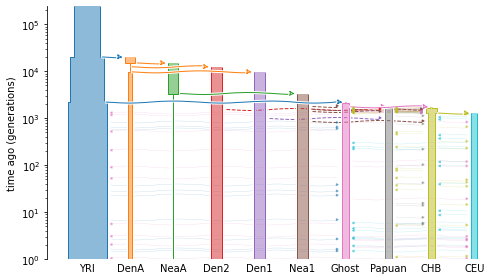

In [42]:
model_graph = demes.load("Prac7_data/HomSap__PapuansOutOfAfrica_10J19.yaml") #model with archaic gene flow

demesdraw.tubes(model_graph, log_time=True)

We want to test the hypothesis of gene flow between archaics and modern humans. For our parametric bootstrap, we therefore want to use a **null model that does not include any gene flow**. We will use a modified version of the model above with the admixture 'pulses' removed.

<AxesSubplot:ylabel='time ago (generations)'>

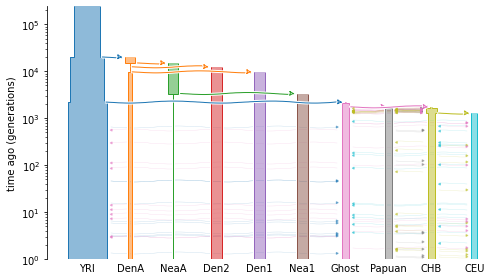

In [43]:
model_graph = demes.load("Prac7_data/HomSap__PapuansOutOfAfrica_10J19_NoArchaicPulses.yaml") # model without archaic gene flow

demesdraw.tubes(model_graph, log_time=True)

Although this model contains more populations than we have analysed, we will keep them all in the model, because gene flow between them can influence the results.

### 3.3.2. Bootstrapping the D statistic

To test whether our D statistic differs significantly from zero, we will perform a parametric bootstrap by simulating a D statistic hundreds or thousands of times under this null model and comparing these values to our observed value. This involves the following steps:
1. Simulate a treesequence under the null model (using the human chromosome 1 recombination map to keep things accurate
2. Add mutations into the treesequence under a realistic mutational model
3. Extract a genotye matrix
4. Compute allele frequencies and from these the D statistic.
5. Repeat steps 1-4 1000 times and compare the values to teh observed value

Unfortunately, each one of these simulations takes a few hours, so we will not be running through these steps now. See Appendix A2 for complete code for simulation and computation of D for human chromosome 1 under the model above.

For this practical we will simply import 200 simulated D statistics from simulations that have been run for you and compare these to the observed value. These are saved as a text file with three columns: ABBA, BABA and D.

In [44]:
#import simulated values
sim_D = np.loadtxt("Prac7_data/sim_D_200.txt")

We can assess visually how our observed D value compares to those simulated under the null model.

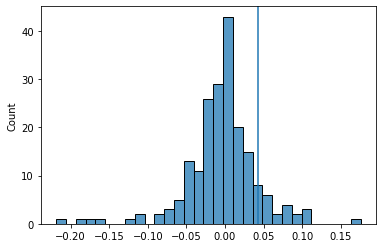

In [45]:
sns.histplot(sim_D)
D = 0.043
plt.axvline(D, 0,200)

This looks less than convincing. But let's calculate the p-value.

<div class="alert alert-block alert-success">    
    <b>Exercise 11:</b>

Calculate the p-value for the test of whether our D value is greater than expected through chance alone under the null model. The p-value is the proportion of simulated D values that are greater than or equal to the observed value.
    
**Hint:** Use the `>=` operator to make a logical array stating whether each simulated value is larger (`True`) or not larger (`False`) than the observed D. Applying the `.sum()` function to a logical array returns the number of `True` values. Then divide by the total number of simulated values. 
</div>

In [46]:
#SOLUTION:
greater = sim_D >= D

p = greater.sum()/len(sim_D)

print("p-value:", p)

p-value: 0.105


<div class="alert alert-block alert-success">    
    <b>Class discusssion:</b>

1. What does this p-value tell us about the evidence for introgression?
2. Do you think we would have had a different result if we had analysed the whole genome? Why?

</div>

---
---
# Appendix A1. Extracting derived allele frequencies from a multi-sample VCF

Above we used allelel frequencies to compute ABBA BABA statistics. This appendix covers the steps to obtain derived allele frequencies from a multi-sample VCF using the code below. This file contains 10 individuals each from 26 1000 Genomes project populations, one Neanderthal, one Denisovan and one Chimpanzee.

First load the VCF file.

In [125]:
query_fields = ['samples', 'calldata/GT']
vcf_dict = allel.read_vcf('Prac7_data/1000Gsubset_ALT_DEN_chimp.chr1.SNP.vcf.gz', fields=query_fields)

### A1.1 Generating and filtering the genotype array

We will convert the data into a `allel.GeotypeArray`object, to take advantage of the inbuilt function to help us compute allele frequencies.

In [126]:
genotypes = allel.GenotypeArray(vcf_dict['calldata/GT'])

genotypes

<GenotypeArray shape=(1979265, 263, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 ./.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/.
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/.

Note that there are now 263 samples: 260 modern humans, 1 Neanderthal, 1 Denisovan and 1 chimp (that's Clint!).

As before, we only want biallelic sites. Although the genotypes are displayed as `0/0` or `./.` (for missing data). The underlying data still consists of the values `0` for reference allele, `1`,`2` etc for alternate and `-1` for missing. We can therefore once again take those sites at which the highest alternate allele code is `1` as niallelic sites. We have to use the `max()` function twice: first to get the maximum value per site, and then to get the maximum value in the two alleles carried by each individual.


In [127]:
#biallelic sites are sites at which the maximum genotype is 1
biallelic = genotypes.max(axis=1).max(axis=1) == 1

genotypes = genotypes[np.where(biallelic)]

genotypes.n_variants

1962776

### A1.2 Storing population info for each sample

Each population in the 1000 Genomes data is represented by 10 samples. To count alleles, `allel` needs a dictionary giving the **index positions** for each population (i.e. which columns in the GenotypeArray). For example individuals from population `GBR` occupy columns 100-109. The 1000 genomes sample names are uninformative, so we load an additional file that tells us which population each sample comes from, and then retrieve its index position in the vcf.

<div class="alert alert-block alert-warning">
    <b>Python recipe: defaultdict</b> 

A <code>defaultdict</code> is a dictionary with a useful twist. When you try to access a key that is not yet in the dictionary, it automatically adds that key, and along with a corresponding default value of your choosing. For example <code>defaultdict(list)</code> creates a defaultdict that will create an empty list for each new key.

**Why is this useful?** Below we will read through a text file line by line, which gives sample names and the population the belong to. For each sample, we will add its index position to a list depending on which population it comes from. These lists are stored in a dictionary. But what happens if we encounter a sample from a population we have not yet seen? We would normally need to add a *new key* to the dictionary. `defaultdict` avoids this problem. When we ask it to add the current sample to the appropriate population, if the population is not yet a key in the dictionary, it will first be added along with an empty list as its value, and then the sample will be added to that list as requested. This way, we avoid having to check that a key is present in the dictionary before modifying its corresponding value. </div>

In [129]:
#A defaultdict to store the sample indices for each population
pop_idx_dict = defaultdict(list)

#extract sample list from vcf header. We use this to find the index (position) of each sample from each population
vcf_samples = list(vcf_dict["samples"])

#now run through the sample populations file to assign individuals to each population
with open("Prac7_data/1000Gsubset_ALT_DEN_chimp.pops.txt", "rt") as popsfile:
    for line in popsfile:
        sample, population = line.split()
        idx = vcf_samples.index(sample)
        pop_idx_dict[population].append(idx) 

#we can now get a list of populations, which are represented by the keys of the dictionay
pops = tuple(pop_idx_dict.keys())

#Print the new dictionary to check the sample indices
for pop in pops:
    print(pop, pop_idx_dict[pop])


ACB [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ASW [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
BEB [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
CDX [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
CEU [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
CHB [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
CHS [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
CLM [70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
ESN [80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
FIN [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
GBR [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
GIH [110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
GWD [120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
IBS [130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
ITU [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
JPT [150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
KHV [160, 161, 162, 163, 164, 165, 166, 167, 168, 169]
LWK [170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
MSL [180, 181, 182, 183, 184, 185, 186, 187, 188, 189]
MXL [190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
PEL [200, 

See that the 1000 Genomes populations each consist of 10 samples while the Neanderthal, Denisovan and Chimp each have 1.

### A1.3 Allele frequencies

We will use allele frequencies in each population for the ABBA BABA computation.

First we will count the total number of observed reference (`0`) and alternate (`1`) alleles in each population. For this, we use the population index dictionary we made above.

In [130]:
allele_counts = genotypes.count_alleles_subpops(pop_idx_dict)

#Inspect some examples
for pop in ["GBR", "NEA", "CHIMP"]:
    print(pop)
    print(allele_counts[pop])

GBR
20  0
14  6
20  0
...
20  0
20  0
20  0

NEA
2 0
2 0
2 0
...
2 0
2 0
2 0

CHIMP
1 0
0 0
1 0
...
1 0
1 0
1 0



Here the first number for each site is the number of copies of the reference allele, and the second number is the number of copies of the alternate allele.

Note how the sum of allele counts for each population is the total number of haplotypes in that population. The chimp data has just one haplotype because it was haploid (it was made by aligning a haploid referecne genome to the human genome). Sites at which there is missing data are those where the number of reference and alternate alleles is zero.

Once again, we now need to polarize our data: instead of counts of reference and alternate, we want counts of `ancestral` and `derived` alleles. We will again use the chimp to achive this, under the assumption that that the allele observed in the chimp (which is haploid) is always the ancestral allele. Therefore any site at which the chimp has the alternate base needs to be 'flipped'. At these sites, we will swap the counts of reference and alternate so that they match ancestral and derived.

In [131]:
#identify sites where flipping is necessary
sites_to_flip = np.where(np.all(allele_counts["CHIMP"] == [0,1], axis=1))

# for each population, flip the sites by reversing the allele counts
for pop in pops:
    allele_counts[pop][sites_to_flip] = allele_counts[pop][sites_to_flip][:,::-1]

Finally, we convert the allele counts to allele frequencies (i.e. a value between 0 and 1 giving the proportion of the population sample made up of derived alleles. We will save these in a pandas dataframe for eacy export to a text file.

In [132]:
#make an empty dataframe
allele_freqs = pd.DataFrame()

#divide the derived allel count by the total allele count
for pop in pops:
    allele_freqs[pop] = allele_counts[pop][:,1] / allele_counts[pop].sum(axis=1)

allele_freqs

/tmp/ipykernel_60030/2774168745.py:6: RuntimeWarning: invalid value encountered in true_divide
  allele_freqs[pop] = allele_counts[pop][:,1] / allele_counts[pop].sum(axis=1)


,ACB,ASW,BEB,CDX,CEU,CHB,CHS,CLM,ESN,FIN,...,MXL,PEL,PJL,PUR,STU,TSI,YRI,NEA,DEN,CHIMP
0,0.00,0.00,0.05,0.0,0.20,0.0,0.0,0.10,0.00,0.05,...,0.00,0.0,0.05,0.10,0.0,0.00,0.00,0.0,0.0,0.0
1,0.00,0.00,0.30,0.0,0.35,0.0,0.0,0.25,0.00,0.30,...,0.15,0.0,0.30,0.20,0.2,0.15,0.00,0.0,0.0,NaN
2,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.05,0.00,0.0,0.00,0.00,0.0,0.0,0.0
3,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.10,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.05,0.00,0.0,0.0,0.0
4,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.05,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962771,0.05,0.05,0.00,0.0,0.00,0.0,0.0,0.00,0.15,0.00,...,0.00,0.0,0.00,0.05,0.0,0.00,0.25,0.0,0.0,0.0
1962772,1.00,1.00,1.00,1.0,1.00,1.0,1.0,1.00,1.00,1.00,...,1.00,1.0,1.00,1.00,1.0,1.00,1.00,1.0,1.0,0.0
1962773,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0
1962774,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0


Don't worry about the warning. This is because some sites have missing data (no alleles observed) so we are dividing by zero. This is not a problem as these sites just get a frequency value `nan`, and will be excluded from any calculation.

Write allele frequencies to a text file, with gzip compression to save space. `index=False` tells pandas not to add a first column giving line numbers.

In [16]:
allele_freqs.to_csv("Prac7_data/1000G_ALT_DEN_chimp.chr1.freqs.csv.gz", index=False, compression="gzip")

---
## Appendix A2: Computing the D statistic from simulated data

Because the bootstrapping simulations take a long time, we ran them for you. The text below walks through the steps of how these simulations were done.


### A2.1 Load the null demographic model

First we load the demographic model from the .yaml file and convert this model into an `msprime.Dempgraphy` object.

In [53]:
model_graph = demes.load("Prac7_data/HomSap__PapuansOutOfAfrica_10J19_NoArchaicPulses.yaml") # model without archaic gene flow

demography = msprime.Demography.from_demes(model_graph)

### A2.2 Load the recombination map for human chromosome 1

Since we have used chromosome 1 for our analysis, we want our simulation to have the same chromosome length and recombination landscape. We therefore import a published genetic map for human chromosome 1 using `msprime`.

In [54]:
recombination_map = msprime.RateMap.read_hapmap("Prac7_data/genetic_map_GRCh37_chr1.txt.gz")

### A2.3 Simulate treesequence and mutations for chr1

We can now simulate the treesequence, ensuring that we sample 10 individuals each from the YRI (African) and CEU (European) populations, and one Altai Neanderthal.

**NOTE: this large simulation will take a few hours to run**

In [26]:
ts = msprime.sim_ancestry(samples={"YRI": 10, "CEU": 10, "NeaA":1},
                          demography=demography, recombination_rate = recombination_map,
                          ploidy=2, record_provenance=False) #record_provenance=False just saves a little bit of memory

Now instead of assessing the genealogies directly as we did earlier, we want to extract mutations so that we can identify ABBA and BABA sites. Currently our treesequence does not contain any mutations, so we need to add these using a second simulation step. First we define the mutation model. We will use the [HKY model](https://en.wikipedia.org/wiki/Models_of_DNA_evolution#HKY85_model_(Hasegawa,_Kishino_and_Yano_1985)), which has different rates for transistions and transversions, as well as different frequencies of purines and pyrimidines. This affects the probability of recurrent mutation at the same site, and is therefore necessary for a realistic simulation of ABBA and BABA sites.

In [27]:
#HKY model with transition/transversion ratio of 2.1 and GC content of 0.6.
mutation_model = msprime.HKY(kappa=2.1, equilibrium_frequencies=[0.3, 0.2, 0.2, 0.3])

Now simulate mutations onto the treesequence

In [28]:
mts = msprime.sim_mutations(ts, rate=1e-8, model=mutation_model)

### A2.4 Genotype matrix from treesequence

We can extract a geotype matrix and generate a allel.HaplotypeArray object. We do not use allel. GenotypeArray because the simulation generates haploid sequences (2 haplotypes per diploid individual in the simulation).

In [29]:
haplotypes = allel.HaplotypeArray(mts.genotype_matrix())

haplotypes

<HaplotypeArray shape=(1659390, 42) dtype=int8>
1 0 0 1 1 ... 1 0 1 1 1
0 0 1 0 0 ... 0 0 0 0 0
0 0 0 0 1 ... 0 0 0 0 0
...
0 0 0 1 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 0 0 0 0 ... 0 0 0 1 1

As we did before, we can ratain only biallelic sites. Since this is a 2-dimensional haplotype array, we just need to take the maximum of the first dimension and confim that it is 1.

In [38]:
biallelic = haplotypes.max(axis=1) == 1

haplotypes = haplotypes[np.where(biallelic)]

### A2.5 Allele frequencies

To calculate allele counts using `allel`, we need a dictionary giving the indices of each population in the haploype matrix. Since we sampled 10 diplioids from YRI. These represent indices 0 to 19. Likewise CEU is at indices 20 to 39. We sampled just one Neanderthal, which has indices 40 and 41.

In [40]:
pop_idx_dict = {"YRI": list(range(0,20)), "CEU": list(range(20,40)), "NEA": list(range(40,42))}

allele_counts = haplotypes.count_alleles_subpops(pop_idx_dict)

allele_counts

{'YRI': <AlleleCountsArray shape=(1471142, 2) dtype=int32>
  8 12
 14  6
 17  3
 ...
 18  2
 19  1
 18  2,
 'CEU': <AlleleCountsArray shape=(1471142, 2) dtype=int32>
  6 14
 16  4
 20  0
 ...
 20  0
 20  0
 16  4,
 'NEA': <AlleleCountsArray shape=(1471142, 2) dtype=int32>
 0 2
 2 0
 2 0
 ...
 2 0
 2 0
 0 2}

Now compute the derived allele frequency by dividing the second column in the allele counts by the total for each population.

In [133]:
#make an empty dataframe
allele_freqs = pd.DataFrame()

#divide the derived allel count by the total allele count
for pop in ["YRI", "CEU", "NEA"]:
    allele_freqs[pop] = allele_counts[pop][:,1] / allele_counts[pop].sum(axis=1)

allele_freqs

/tmp/ipykernel_60030/3330106910.py:6: RuntimeWarning: invalid value encountered in true_divide
  allele_freqs[pop] = allele_counts[pop][:,1] / allele_counts[pop].sum(axis=1)


,YRI,CEU,NEA
0,0.00,0.20,0.0
1,0.00,0.35,0.0
2,0.00,0.00,0.0
3,0.00,0.00,0.0
4,0.05,0.00,0.0
...,...,...,...
1962771,0.25,0.00,0.0
1962772,1.00,1.00,1.0
1962773,0.00,0.00,0.0
1962774,0.00,0.00,0.0


### A2.6 ABBA BABA statistics

Finally, we can calculate ABBA, BABA, D and f from the allele frequencies. Although we did not simulate the outgroup, we know that it should have the ancestral allele at all sites, so its derived allele frequency can simply be set to 0 and this will be applied to all sites.

In [134]:
#define populations to use
P1, P2, P3 = "YRI", "CEU", "NEA"

#ABBA and BABA
print("ABBA:", get_ABBA(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], 0))
print("BABA:", get_BABA(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], 0))

#Get D directly
print("D:", get_D(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], 0))

#Get f
print("f:", get_f(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], 0))

ABBA: 16854.626249999987
BABA: 15592.976249999987
D: 0.03888268786576761
f: 0.015795448534587638


For the full bootstrap, the above procedure was repeated 200 times to produce a null distribution of D values for chromosome 1.